In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 5.5MB/s 
     |████████████████████████████████| 12.8MB 187kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2012)

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,2008_000002.jpg,tvmonitor,True
1,2008_000003.jpg,train person,True
2,2008_000007.jpg,boat,True
3,2008_000008.jpg,horse person,False
4,2008_000009.jpg,cow,True


In [ ]:
df['fname']

0        2008_000002.jpg
1        2008_000003.jpg
2        2008_000007.jpg
3        2008_000008.jpg
4        2008_000009.jpg
              ...       
11535    2011_003269.jpg
11536    2011_003271.jpg
11537    2011_003274.jpg
11538    2011_003275.jpg
11539    2011_003276.jpg
Name: fname, Length: 11540, dtype: object

In [ ]:
dblock = DataBlock()
dsets = dblock.datasets(df)
len(dsets.train),len(dsets.valid)

(9232, 2308)

In [ ]:
x,y = dsets.train[0]
x,y

(fname       2008_008379.jpg
 labels                train
 is_valid               True
 Name: 4143, dtype: object, fname       2008_008379.jpg
 labels                train
 is_valid               True
 Name: 4143, dtype: object)

In [ ]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('2008_007595.jpg', 'car')

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2012/train/2009_001768.jpg'),
 ['person', 'sheep'])

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x338,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['person']

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x442,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
         0., 0.]))

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
# Find the address of images
dls = dblock.dataloaders(df)

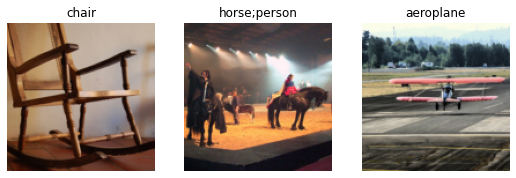

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.859989,0.621989,0.234493,01:35
1,0.576901,0.232426,0.737713,01:33
2,0.230165,0.115349,0.944728,01:33
3,0.144474,0.105510,0.952782,01:33


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.115561,0.102869,0.951150,01:39
1,0.102624,0.095828,0.954139,01:37
2,0.081420,0.091798,0.955779,01:36


In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.dls.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])